**Submitted by: Md Merajul Islam**

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [18]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

In [20]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [21]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/gdrive/My Drive/Colab Notebooks/Skin_cancer/Train')
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Colab Notebooks/Skin_cancer/Test')

In [22]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [23]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [24]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [25]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [26]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

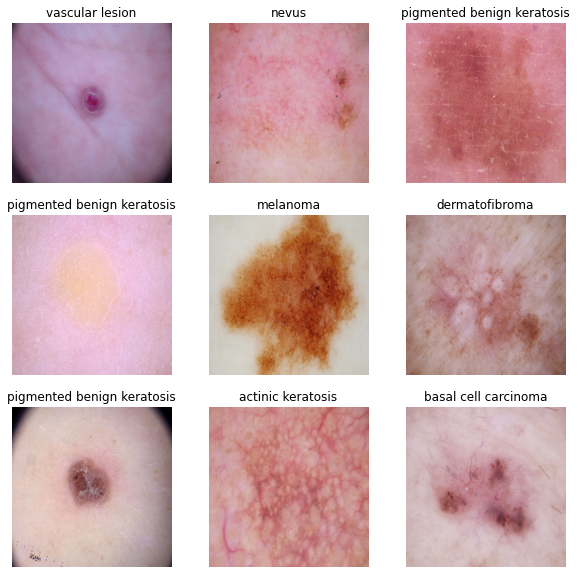

In [27]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

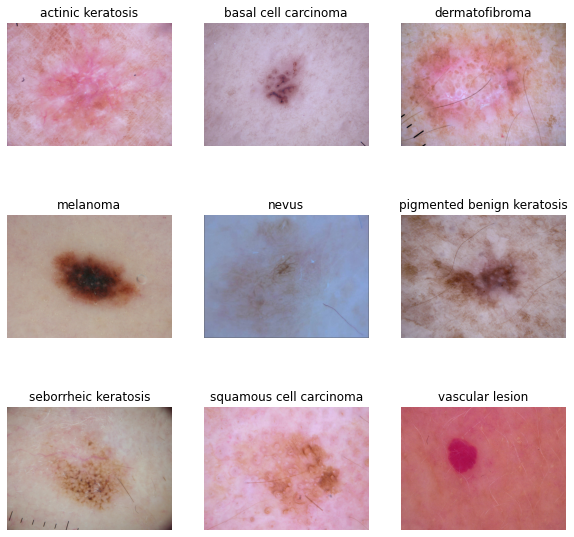

In [28]:
import matplotlib.image as mpimg
plt.figure(figsize=(10,10))
for i in range(9): 
    plt.subplot(3, 3, i + 1)
    image = mpimg.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
    plt.title(class_names[i])
    plt.imshow(image)
    plt.axis("off")

In [29]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [31]:
### Your code goes here
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.1395442 0.9800654


Notice the pixels values are now in between the range 0 to 1

##### The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a softmax function.

In [32]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax'),
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

- As it is a multi class classification, we are using **SparseCategoricalCrossEntropy** as the loss function, and we are using **adam** or **Adaptive Moment Estimation** optimizer as a hit & trial, further we can perform hyper parameter optimization and change the optimizer accordingly

In [33]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [34]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)       

### Train the model

In [35]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 22s 387ms/step - loss: 2.0055 - accuracy: 0.2489 - val_loss: 1.9015 - val_accuracy: 0.3020
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.7886 - accuracy: 0.3504 - val_loss: 1.6248 - val_accuracy: 0.4855
Epoch 3/20
56/56 [==============================] - 2s 41ms/step - loss: 1.5025 - accuracy: 0.4754 - val_loss: 1.4914 - val_accuracy: 0.5190
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3352 - accuracy: 0.5402 - val_loss: 1.3926 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.1966 - accuracy: 0.5865 - val_loss: 1.3594 - val_accuracy: 0.5347
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.1079 - accuracy: 0.6060 - val_loss: 1.3160 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.0095 - accuracy: 0.6445 - val_loss: 1.3562 - val_accuracy: 0.5391
Epoch 8/20


### Visualizing training results

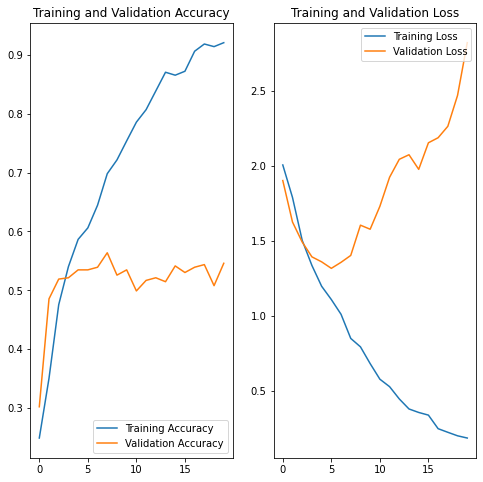

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
#Checking the maximum accuracy of training and validation
print("Maximum accuracy of training data : ",
      round(max(history.history['accuracy'])*100,4))

print("Maximum accuracy of validation data: ",
      round(max(history.history["val_accuracy"])*100,4))

Maximum accuracy of training data :  92.0759
Maximum accuracy of validation data:  56.3758


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples, to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

As we can see from the plots, training accuracy and validation accuracy are off by large margin. The model has achieved only around 57% accuracy on the validation set but the training accuracy is around 85%.

Let's look at what went wrong and try to increase the overall performance of the model.

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 55% in the training process. Also, the big difference in accuracy between training and validation accuracy is a clear sign of overfitting.

There are multiple ways to fight overfitting in the training process. In this case we will use data augmentation and add Dropout to our model.

### Data augmentation:
Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from our existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [38]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

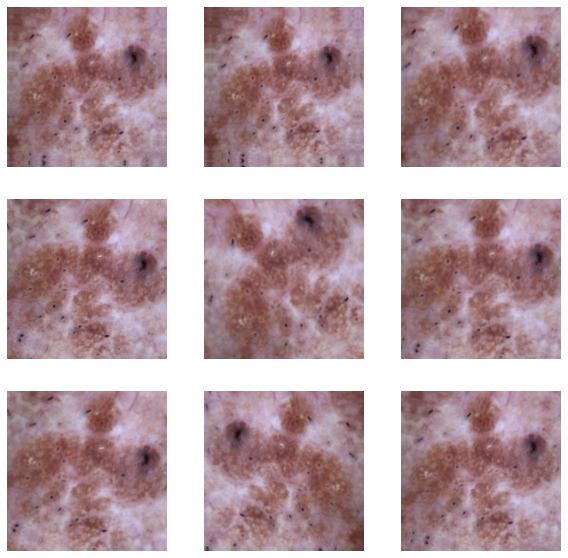

In [39]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


### Todo:
### Create the model, compile and train the model


Another technique to reduce overfitting is to introduce Dropout to the network, a form of regularization.

When we apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

In [40]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

num_classes = 9

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),## added dropout layer
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

### Compiling the model

In [41]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)       

### Training the model

In [42]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 52ms/step - loss: 1.9141 - accuracy: 0.3036 - val_loss: 1.6573 - val_accuracy: 0.4004
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 1.6134 - accuracy: 0.4163 - val_loss: 1.5715 - val_accuracy: 0.4385
Epoch 3/20
56/56 [==============================] - 3s 48ms/step - loss: 1.4670 - accuracy: 0.4888 - val_loss: 1.4222 - val_accuracy: 0.5056
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.4062 - accuracy: 0.5089 - val_loss: 1.4386 - val_accuracy: 0.5011
Epoch 5/20
56/56 [==============================] - 3s 47ms/step - loss: 1.3405 - accuracy: 0.5318 - val_loss: 1.3968 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 3s 48ms/step - loss: 1.3648 - accuracy: 0.5033 - val_loss: 1.4496 - val_accuracy: 0.4989
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.3060 - accuracy: 0.5419 - val_loss: 1.3818 - val_accuracy: 0.5168
Epoch 8/20
56

### Visualizing the results

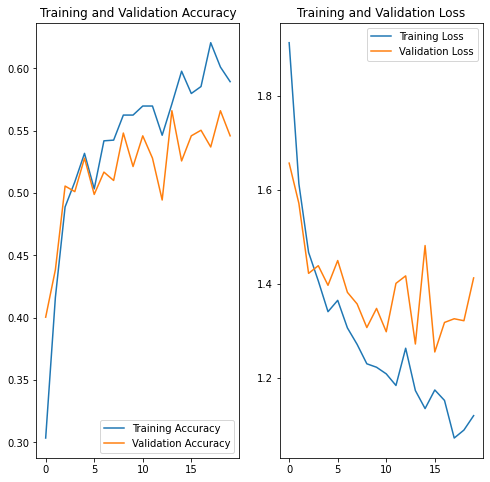

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
#Checking the maximum accuracy of training and validation
print("Maximum accuracy of training data : ",
      round(max(history.history['accuracy'])*100,4))

print("Maximum accuracy of validation data: ",
      round(max(history.history["val_accuracy"])*100,4))

Maximum accuracy of training data :  62.0536
Maximum accuracy of validation data:  56.5996


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Ans:** <br>

**Findings:**

We don't see much improvements with respect to accuracy from the base model, but we can definitely see the overfitting issue fading away due to data augmentation as the difference between training and validation accuracy has come much closer.

But again, judging based on just 20 epochs won't give us proper conclusions.

Lets now try to improve the accuracy of our model.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

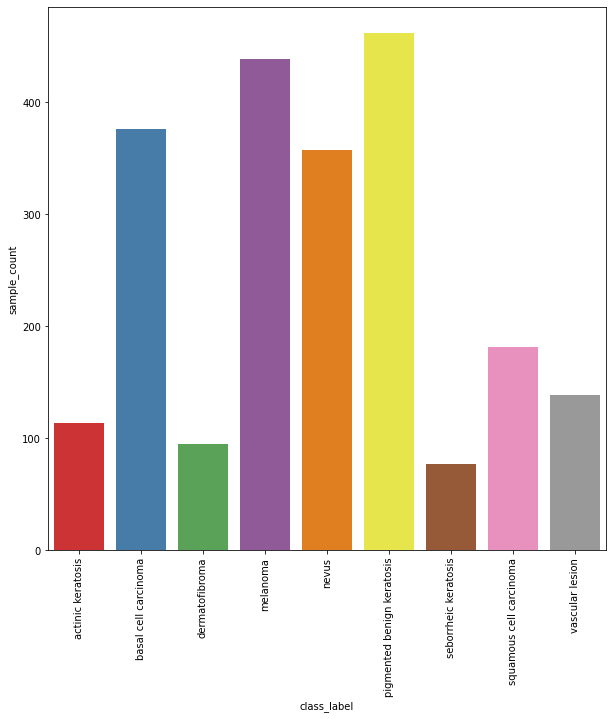

,sample_count,class_label
0,114,actinic keratosis
1,376,basal cell carcinoma
2,95,dermatofibroma
3,438,melanoma
4,357,nevus
5,462,pigmented benign keratosis
6,77,seborrheic keratosis
7,181,squamous cell carcinoma
8,139,vascular lesion


In [45]:
## Your code goes here.
import seaborn as sns


sample_count = []
class_label = []
for i in class_names:
    samplelist = os.listdir(str(data_dir_train) + "/" + i)
    sample_count.append(len(samplelist))
    class_label.append(i)

df = pd.DataFrame({'sample_count': sample_count, 'class_label':class_label})

plt.figure(figsize=(10, 10))
sns.barplot(x='class_label', y='sample_count',  palette = "Set1", data=df)
plt.xticks(rotation=90)
plt.show()

df

#### **Todo:** Write your findings here: 
From the above plot we can clearly see there is class imbalance here. Some classes has very high number of samples where some classes have comparatively less number of samples.

#### - Which class has the least number of samples?
**Ans:** "seborrheic keratosis" has the least number of samples which is 77.

#### - Which classes dominate the data in terms proportionate number of samples?

**Ans:** There are four classes which dominates the data in terms number of samples.

**pigmented benign keratosis** which has **462** samples<br>
**melanoma** which has **438** samples<br>
**basal cell carcinoma** which has **376** samples<br>
**nevus** which has **357** samples<br>

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [47]:
pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [48]:
path_to_training_dataset= '/content/gdrive/My Drive/Colab Notebooks/Skin_cancer/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin_cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F148CD2D750>: 100%|██████████| 500/500 [00:23<00:00, 20.84 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin_cancer/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1502CEAE50>: 100%|██████████| 500/500 [00:24<00:00, 20.59 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin_cancer/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F148CF62ED0>: 100%|██████████| 500/500 [00:24<00:00, 20.27 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin_cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1502CF0E90>: 100%|██████████| 500/500 [01:40<00:00,  4.96 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin_cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F148CD2D190>: 100%|██████████| 500/500 [01:43<00:00,  4.81 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin_cancer/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F148CDB3ED0>: 100%|██████████| 500/500 [00:24<00:00, 20.79 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin_cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1502CF0710>: 100%|██████████| 500/500 [00:53<00:00,  9.34 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin_cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1502CEA690>: 100%|██████████| 500/500 [00:23<00:00, 20.90 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin_cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F148CFF26D0>: 100%|██████████| 500/500 [00:24<00:00, 20.53 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [54]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [55]:
import glob
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/My Drive/Colab Notebooks/Skin_cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028063.jpg_ec61fe31-351a-4d09-893a-87017304abbf.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Skin_cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032437.jpg_f8f256b1-e2b3-4468-a9fd-bc47325a4884.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Skin_cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027254.jpg_e7e85f55-7a2b-460c-958b-002133b82f6f.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Skin_cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028990.jpg_db7a00fc-5945-40b1-afa7-02f8fb9176b1.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Skin_cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028063.jpg_51dcfc12-5172-40c8-b03a-dd807cba3c39.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Skin_cancer/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028558.jpg_cba86

In [56]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [57]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2.head(10)

,Path,Label
0,/content/gdrive/My Drive/Colab Notebooks/Skin_...,actinic keratosis
1,/content/gdrive/My Drive/Colab Notebooks/Skin_...,actinic keratosis
2,/content/gdrive/My Drive/Colab Notebooks/Skin_...,actinic keratosis
3,/content/gdrive/My Drive/Colab Notebooks/Skin_...,actinic keratosis
4,/content/gdrive/My Drive/Colab Notebooks/Skin_...,actinic keratosis
5,/content/gdrive/My Drive/Colab Notebooks/Skin_...,actinic keratosis
6,/content/gdrive/My Drive/Colab Notebooks/Skin_...,actinic keratosis
7,/content/gdrive/My Drive/Colab Notebooks/Skin_...,actinic keratosis
8,/content/gdrive/My Drive/Colab Notebooks/Skin_...,actinic keratosis
9,/content/gdrive/My Drive/Colab Notebooks/Skin_...,actinic keratosis


In [58]:
df2['Label'].value_counts()

melanoma                      500
pigmented benign keratosis    500
dermatofibroma                500
seborrheic keratosis          500
squamous cell carcinoma       500
actinic keratosis             500
vascular lesion               500
basal cell carcinoma          500
nevus                         500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [59]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [60]:
data_dir_train= pathlib.Path('/content/gdrive/My Drive/Colab Notebooks/Skin_cancer/Train')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [61]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [62]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In our final model we have added two additonal convolution layers.

We have also added Batch normalization as this is a layer that allows every layer of the network to do learning more independently. It is used to normalize the output of the previous layers. The activations scale the input layer in normalization. Using batch normalization learning becomes efficient also it can be used as regularization to avoid overfitting of the model.

In [70]:
## your code goes here
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),

  layers.BatchNormalization(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [72]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 180, 180, 3)       12        
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
batch_normalization_22 (Batc (None, 180, 180, 16)      64        
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 90, 90, 32)       

#### **Todo:**  Train your model

In [73]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 17s 86ms/step - loss: 1.9148 - accuracy: 0.4052 - val_loss: 4.0059 - val_accuracy: 0.1789
Epoch 2/30
169/169 [==============================] - 14s 83ms/step - loss: 1.4339 - accuracy: 0.4874 - val_loss: 1.7620 - val_accuracy: 0.4009
Epoch 3/30
169/169 [==============================] - 14s 83ms/step - loss: 1.2870 - accuracy: 0.5274 - val_loss: 1.6286 - val_accuracy: 0.4818
Epoch 4/30
169/169 [==============================] - 14s 82ms/step - loss: 1.1594 - accuracy: 0.5690 - val_loss: 1.1590 - val_accuracy: 0.5902
Epoch 5/30
169/169 [==============================] - 14s 83ms/step - loss: 1.0784 - accuracy: 0.6081 - val_loss: 1.3620 - val_accuracy: 0.5783
Epoch 6/30
169/169 [==============================] - 14s 82ms/step - loss: 0.9691 - accuracy: 0.6371 - val_loss: 0.9340 - val_accuracy: 0.6682
Epoch 7/30
169/169 [==============================] - 14s 82ms/step - loss: 0.8916 - accuracy: 0.6606 - val_loss: 1.1925 - val_accuracy:

#### **Todo:**  Visualize the model results

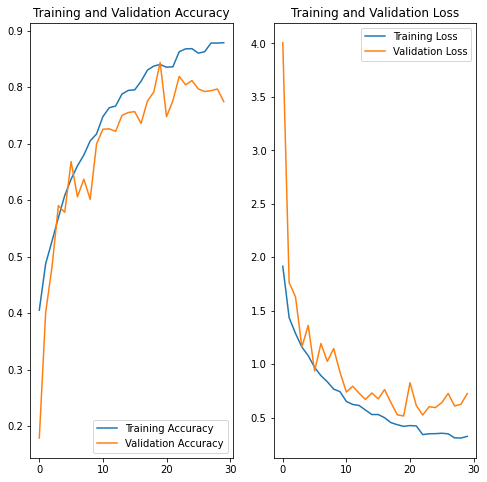

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [75]:
#Checking the maximum accuracy of training and validation
print("Maximum accuracy of training data : ",
      round(max(history.history['accuracy'])*100,4))

print("Maximum accuracy of validation data: ",
      round(max(history.history["val_accuracy"])*100,4))

Maximum accuracy of training data :  87.8524
Maximum accuracy of validation data:  84.3356


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



As we can see from the plots the the Training and validation accuracy are pretty close now. So we can conclude,

*   Underfitting or overfitting issues are now resolved. As there is not much difference between training and validation acuuracy.


*   After augmentation the effect of class imbalance in our model performance has faded and it is evident from the fact that the overall accuracy has increased significantly.